In [1]:
from os.path import join as pathjoin
from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data/min_gpt'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_rubert'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_transformer_model(vocab, transformer_model)

Building the model


In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A8', 1: 'A12', 2: 'A1', 3: 'A14', 4: 'A11', 5: 'A17', 6: 'A16', 7: 'A4', 8: 'A9', 9: 'A7'}
dict_values(['A8', 'A12', 'A1', 'A14', 'A11', 'A17', 'A16', 'A4', 'A9', 'A7'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 1
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

1


<All keys matched successfully>

### Data loading

In [7]:
ru_test_df = pd.read_csv(pathjoin(DATA_DIR, 'ru'))
ru_test_df.head()

,Unnamed: 0,target,text
0,0,A4,"Жеффре . Надеюсь все пробирала так скверно , ч..."
1,1,A4,У . Она будет крестить вас Духом Святым . 9 И ...
2,2,A4,"Ь спросил его : что же ты крестишь , если ты н..."
3,3,A4,"Очень странное . — Вы говорите , что я мерзавк..."
4,4,A4,Кордин из них убил красивых пурпурных и травян...


In [8]:
true_classes = ru_test_df.target.values
sentences = ru_test_df.text.values

### Preliminary analysis

In [9]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

In [10]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [11]:
print(len(np.unique(true_classes)))

10


In [12]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.6111111111111112 precision 0.55 recall 0.6875
label (fictive) f1_score 0.9500000000000001 precision 0.95 recall 0.95
label (instruct) f1_score 0.9 precision 0.9 recall 0.9
label (reporting) f1_score 0.7169811320754716 precision 0.95 recall 0.5757575757575758
label (legal) f1_score 0.8780487804878048 precision 0.9 recall 0.8571428571428571
label (personal) f1_score 0.9473684210526316 precision 0.9 recall 1.0
label (commercial) f1_score 0.9285714285714286 precision 1.0 recall 0.8666666666666667
label (research) f1_score 0.7894736842105262 precision 0.75 recall 0.8333333333333334
label (info) f1_score 0.41379310344827586 precision 0.3 recall 0.6666666666666666
label (eval) f1_score 0.9302325581395349 precision 1.0 recall 0.8695652173913043
accuracy 0.8134715025906736


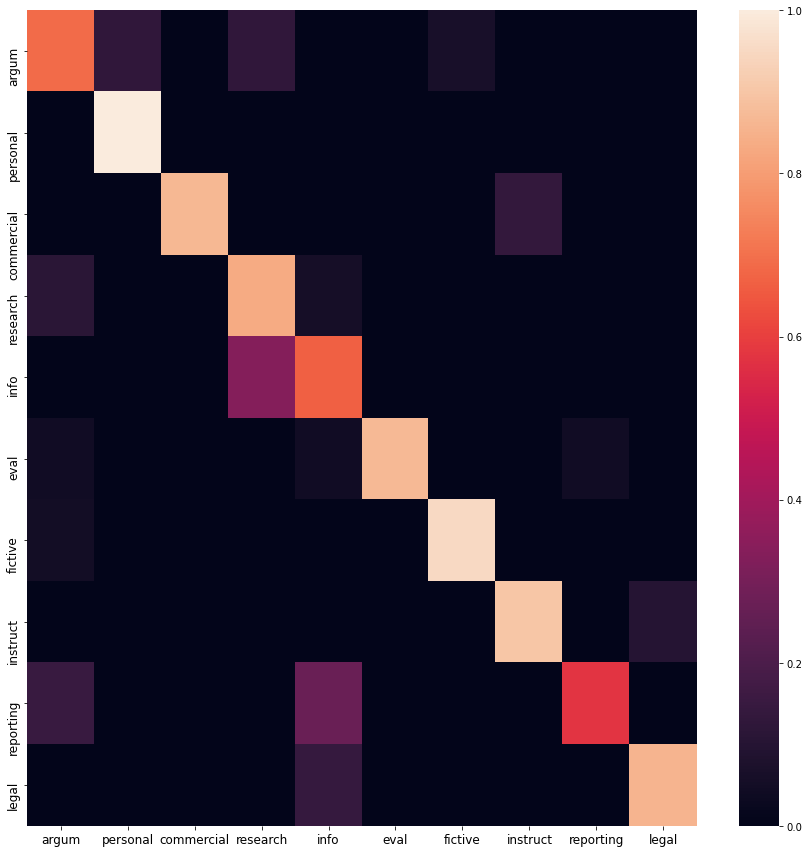

In [13]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [14]:
smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
integrated_grad = IntegratedGradient(predictor)

In [15]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [16]:
interpret_sentence(
    sentences[mistake_ids[0]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

TRUE LABEL: fictive
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
конечно , нет у меня сыновья ? после смеха , довер ##ь моя , что вы приняли счастлива бы это были бы только математики . — вот , — сказал я . — я оспар ##иваю достоинство мышления , развитого каким бы то ни было специальным путем , отлич ##ающимся от отвлеч ##енно ##и логики , а следовательно , и выводы из такого мышления . особенно я оспар ##иваю суждение , построенное на изучении математики . математика — наука форм и количеств ; математическое суждение — ни более , ни менее как простая логика , применен ##ная к количеству и к форме . велич ##аи ##шее заблуждение — предполагать , что истины , которые называют чисто алгебра ##ическими , — в сущности истины безуслов ##ные или общие . и заблуждение это так огром ##но , что я поражен единодуш ##ием , с которым оно принято . математические аксиом ##ы не суть аксиом ##ы истины безусловно ##и . то , что верно , когда отно

In [17]:
interpret_sentence(
    sentences[mistake_ids[1]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

TRUE LABEL: instruct
LABEL: commercial
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
а , то вам же уделить лезвие для бумаги ( брит ##ву ) еще на пару - тро ##ику сантиметров , затем под ##од ##вига ##ете также плавно лезвие кух ##онного ножа на пару сантиметров . т ака ##я последовательность не дает стек ##лу заж ##ать лезвие для бумаги " в тис ##ки " и предотвращает разбив ##ание стекла из - за точ ##ечно ##и локально ##и нагрузки . ит ##ак , вам удалось без повреждении снять переднюю стенку , теперь ее можно отложить в сторону ( она нам больше не понадобится ) и зачист ##ить от остатков старого силик ##она открыв ##шиеся ребра боковых стекол и дна полностью . помнит ##е о технике безопасности и по возможности воспольз ##уи ##тесь перед началом работ строительными перчат ##ками 7 - 10 класса плотности вяз ##ки или старыми кожан ##ыми перчат ##ками , которые не будут стесн ##ять ваших движении . естественно стоит понимать , что для крупногабар

In [18]:
interpret_sentence(
    sentences[mistake_ids[2]], dataset_reader.tokenizer, 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)

TRUE LABEL: instruct
LABEL: commercial
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
х от предложения работы мышц стопы . туловище на вир ##аже наклон ##ено на 3 — 5° вперед , но по мере выхода с вир ##ажа на прямую наклон уменьшается , а руки работают свободно и быстро , способствуя поддержанию высокого темпа бега . в беге на 400 м по все ##и дистанции следует темп и длину шага поддерживать в оптимальных пределах : темп бега у мужчин должен быть равен 3 , 4 — 4 ш / сек , длина шага — 220 — 210 см . после пробега ##ния первых 200 ##м у спортсменов наступает так называемое мним ##ое утом ##ление и большинство из них не в состоянии преодолеть этот рубеж . надо помнить , что у хорошо подготовленного бегун ##а естественное утом ##ление начинается за 50 — 70 м до финиша , если первая половина дистанции преодол ##ена с оптим ##ально ##и скоростью . поэтому при пробега ##нии второго вир ##ажа надо стремиться сохранить длину шага и темп бега и старатьс